In [1]:
# Setup
import re
import os
import json
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

precision = 3
pd.set_option("display.precision", precision)

metrics = {"gameof24": "success_rate", "crosswords": "r_word"}

#############################################
# Just some util and plot styling functions #
#############################################
def get_files_in_folder(folder_path):
    files = []
    for file in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file)):
            files.append(folder_path + "/" +file)
    return sorted(files)

def get_number(string):
    numbers = re.findall(r'\d+', string)
    numbers = list(map(int, numbers))
    return numbers[0]

def get_params(file_path):
    data = {}

    file_name = file_path.split('/')[-1]
    params = file_name.split('_')

    data["set"] = params[0].split("-")[0]
    data["n_agents"] = get_number(params[1])
    data["n_steps"] = get_number(params[2])
    data["k"] = get_number(params[3])
    data["origin_value"] = get_number(params[4])
    data["backtrack"] = float("0." + str(get_number(params[5].split(".")[1])))
    data["resampling"] = params[6].split("-")[0]
    data["file_path"] = file_path
    data["name"] = f"{data['n_agents']}agents\n{data['n_steps']}steps\n{data['k']}k\n{data['backtrack']}b"

    return data

def compute_stats(puzzle_results, costs):
    stats = {}

    
        
    puzzle_results = np.array(puzzle_results)
    performance_stats = bootstrap(puzzle_results.reshape((1,-1)), np.mean)
    stats.update({"performance_mean":performance_stats.bootstrap_distribution.mean()})
    stats.update({"performance_ci":performance_stats.confidence_interval})

    if len(costs) == 1:
        stats.update({"cost_mean":costs[0]})
        stats.update({"cost_ci":(costs[0], costs[0])})
    else:
        costs = np.array(costs)
        cost_stats = bootstrap(costs.reshape((1,-1)), np.mean)
        stats.update({"cost_mean":cost_stats.bootstrap_distribution.mean()})
        stats.update({"cost_ci":cost_stats.confidence_interval})

    return stats

def get_gameof24_puzzle_results_foa(file_path):
    with open(file_path, "r") as experiment_file:
        data = json.load(experiment_file)
    if "mixed" in file_path:
        cost = data.pop("Cost")["Total cost"]["total_cost"]
    else:
        cost = data.pop("Cost")["total_cost"]
    puzzle_results = []
    for _, puzzle in data.items():
        puzzle_results.append(({"r": 1} in puzzle["Verifications"])*1)
    return puzzle_results, cost

def get_crosswords_puzzle_results_foa(file_path, metric="r_letter"):
    with open(file_path, "r") as experiment_file:
        data = json.load(experiment_file)
    cost = data.pop("Cost")["Total cost"]["total_cost"]
    results = {}
    for puzzle_idx, puzzle in data.items():
        n_agents = len(puzzle) - 2 # -2 for "puzzle" and "Verifications"

        # Get the number of actions each agent performed for the puzzle
        puzzle_actions = []
        for agent in range(n_agents):
            agent_steps = puzzle[f"Agent {agent}"]
            agent_actions = []
            for step_id, step in agent_steps.items():
                actions = step.get("Step", "").split(" -> ")
                n_actions =  len(actions)
                agent_actions.append(n_actions)
            puzzle_actions.append(agent_actions)

        # Get the best state for each agent
        best_states = {}
        for agent in range(n_agents):
            best_states[f"Agent {agent}"] = {}
            best_step_idx = puzzle_actions[agent].index(max(puzzle_actions[agent]))
            best_states[f"Agent {agent}"]["Best step idx"] = best_step_idx
            best_states[f"Agent {agent}"]["Best step n_actions"] = max(puzzle_actions[agent])
            best_states[f"Agent {agent}"]["Best step"] = data[puzzle_idx][f"Agent {agent}"][f"Step {best_step_idx}"]
        
        best_agent = max(best_states, key=lambda x: best_states[x]["Best step n_actions"])
        results[puzzle_idx] = best_states[best_agent]

    r_letters = []
    r_words = []
    r_alls = []
    
    for puzzle_idx, result in results.items():
        r_letters.append(result["Best step"]["metrics"]["r_letter"])
        r_words.append(result["Best step"]["metrics"]["r_word"])
        r_alls.append(result["Best step"]["metrics"]["r_all"])
    
    puzzle_results = {"r_letter": r_letters, "r_word": r_words, "r_all": r_alls}
    return puzzle_results[metric], cost

get_task_puzzle_results_foa = {"gameof24": get_gameof24_puzzle_results_foa, "crosswords": get_crosswords_puzzle_results_foa}

In [2]:
# Loading the data
data = {"gameof24":{"cost":{}, "performance":{}, "both":{}, "mixed":{}}, "crosswords":{"cost":{}, "performance":{}, "both":{}, "mixed":{}}}

"""
cost : optimizing for cost
performance : optimizing for performance
both : optimizing for both
mixed : gpt-4 powered evaluation
"""

for task, optimizations in data.items():
    for optimization, experiments in optimizations.items():
        folder = f"logs/{task}/{optimization}"
        files = get_files_in_folder(folder)
        experiments = [get_params(file) for file in files]

        configurations = {}
        for experiment in experiments:
            if experiment["name"] not in configurations:
                configurations[experiment["name"]] = []
            configurations[experiment["name"]].append(experiment)
        
        for configuration, experiments in configurations.items():
            puzzle_results = []
            costs = []
            for experiment in experiments:
                file_path = experiment["file_path"]
                result, cost = get_task_puzzle_results_foa[task](file_path)
                costs.append(cost)
                puzzle_results.extend(result)
            
            # Compute stats
            stats = compute_stats(puzzle_results, costs)
            

            data[task][optimization].update({configuration:{"experiments": experiments, "stats":stats}})

## Benchmarks

In [3]:
def get_gameof24_puzzle_results_tot(file_path, method="ToT"):
    with open(file_path, "r") as experiment_file:
        data = json.load(experiment_file)
    
    # Get cost
    cost = data[-1]["usage_so_far"]["cost"]

    # Get result per puzzle
    puzzle_results = []
    for puzzle in data:
        if method == "ToT":
            puzzle_results.append(({"r": 1} in puzzle["infos"])*1)
        else:
            puzzle_results.append(np.mean([info["r"] for info in puzzle["infos"]]))
    return puzzle_results, cost

def get_crosswords_puzzle_results_tot(file_path, metric="r_letter", method="ToT"):
    with open(file_path) as f:
        data = json.load(f)

    # Get cost
    if method != "ToT": #ie. naive + cot
        cost = data[-1]["usage_so_far"]["cost"]
        r_letters = []
        r_words = []
        r_games = []
        for game in data:
            r_letters.append(np.mean([info["r_letter"] for info in game["infos"]]))
            r_words.append(np.mean([info["r_word"] for info in game["infos"]]))
            r_games.append(np.mean([info["r_game"] for info in game["infos"]]))
    
    else:
        cost = data.pop(-1)["cost"]

        # Get results per puzzle
        best_steps = []
        for game in data:
            step_len = [len(step["actions"]) for step in game]
            if step_len == []:
                # Empty game -> No suggestions at root node
                best_steps.append({"total_step":0, "env_step":0, "actions":[], 'info': {'r_letter': 0, 'r_word': 0},})
                continue
            best_step_index = step_len.index(max(step_len))
            best_step = game[best_step_index]
            best_steps.append(best_step)

        r_letters = [game["info"]["r_letter"] for game in best_steps]
        r_words = [game["info"]["r_word"] for game in best_steps]
        r_games = [1 if game["info"]["r_word"]==1 else 0 for game in best_steps]
        
    puzzle_results = {"r_letter": r_letters, "r_word": r_words, "r_game": r_games}

    return puzzle_results[metric], cost

get_task_puzzle_results_tot = {"gameof24": get_gameof24_puzzle_results_tot, "crosswords": get_crosswords_puzzle_results_tot}

In [4]:
benchmarks = {"gameof24": {"ToT": {}}, "crosswords": {"ToT": {}}} 

methods = ["ToT"] # propose goes for ToT

for task in benchmarks.keys():
    for method in methods:
        folder = f"benchmarks/{task}/{method}"
        files = get_files_in_folder(folder)

        puzzle_results = []
        costs = []

        for file in files:
            result, cost = get_task_puzzle_results_tot[task](file, method=method)
            costs.append(cost)
            puzzle_results.extend(result)

        # Compute stats
        stats = compute_stats(puzzle_results, costs)

        benchmarks[task][method] = stats

## FoA beating ToT

In [5]:
def group_data_per_optimization(data, benchmarks, optimization, task=None):
    results = []

    for task_ in data.keys():

        # Get FoA results
        for configuration, experiment_results in data[task_][optimization].items():
            result = {"task": task_, "method": "FoA", "configuration": configuration}
            result.update(experiment_results["stats"])
            result.update({"optimization": optimization})
            results.append(result)
        
        # Get ToT results
        for method, stats in benchmarks[task_].items():
            result = {"task": task_, "method": method, "configuration": "default"}
            result.update(stats)
            result.update({"optimization": None})
            results.append(result)
    df = pd.DataFrame(results)
    

    for ci in ["performance_ci", "cost_ci"]:
        df[ci] = df[ci].apply(lambda x: (round(x[0], precision), round(x[1], precision)))

    # If a task is specified filter the df
    if task: 
        df = df[df.task==task]
    return df

In [10]:
df = group_data_per_optimization(data, benchmarks, "both")
display(df)
df.drop(columns=["configuration","optimization"]).to_latex("table.tex", index=False)

,task,method,performance_mean,performance_ci,cost_mean,cost_ci
0,gameof24,FoA,0.200,"(0.166, 0.236)",1.462,"(1.413, 1.513)"
1,gameof24,ToT,0.136,"(0.108, 0.17)",1.711,"(1.641, 1.75)"
2,crosswords,FoA,0.387,"(0.344, 0.429)",0.366,"(0.359, 0.372)"
3,crosswords,ToT,0.332,"(0.277, 0.392)",0.481,"(0.376, 0.585)"


## Pareto optimals

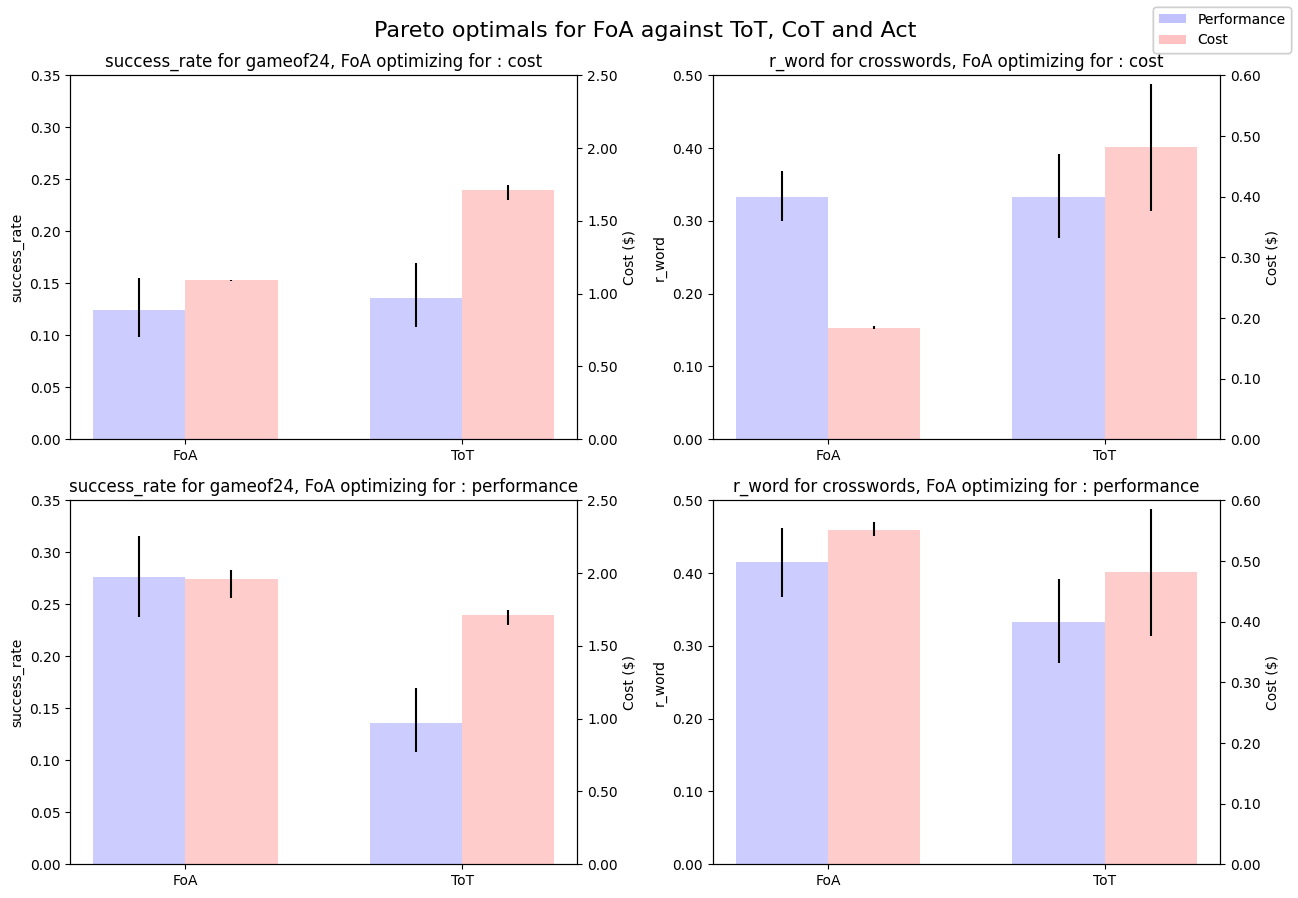

In [7]:
def plot_bars(df, metric_name, metric_axis,  title=None, maxy: tuple=None ):

    cost_axis = metric_axis.twinx()

    width = 0.2

    df_foa = df#[df.method=="FoA"]

    configurations = df_foa["method"].tolist()
    # The x position of bars
    x_metric = [3*i*width for i in range(len(configurations)) ]
    x_cost = [x + width for x in x_metric]

    metric = df_foa["performance_mean"].array
    metric_ci_low = df_foa["performance_ci"].apply(lambda x: x[0]).array
    metric_ci_high= df_foa["performance_ci"].apply(lambda x: x[1]).array
    metric_ci = [np.abs(metric-metric_ci_low), np.abs(metric_ci_high-metric)]

    cost = df_foa["cost_mean"].array
    cost_ci_low = df_foa["cost_ci"].apply(lambda x: x[0]).array
    cost_ci_high= df_foa["cost_ci"].apply(lambda x: x[1]).array
    cost_ci = [np.abs(cost-cost_ci_low), np.abs(cost_ci_high-cost)]

    # Plot the bars
    metric_axis.bar(x_metric, metric, yerr=metric_ci, color="b", width=width,  alpha=0.2, label="Performance")
    cost_axis.bar(x_cost, cost, yerr=cost_ci, color="r", width=width,  alpha=0.2, label="Cost")

    # Handle axes and lebels
    metric_axis.set_ylabel(metric_name)
    cost_axis.set_ylabel("Cost ($)")
    plt.xticks([x + width/2 for x in x_metric], configurations)
    plt.title(title)

    # Combining legends
    lines, labels = metric_axis.get_legend_handles_labels()
    lines2, labels2 = cost_axis.get_legend_handles_labels()
    plt.figlegend(lines + lines2, labels + labels2)

    # Decimals on y axis
    metric_axis.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cost_axis.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Number of ticks in y axis
    n_bins = 8
    metric_axis.locator_params(axis="y", nbins=n_bins)
    cost_axis.locator_params(axis="y", nbins=n_bins)

    # Set ylim if specified
    if maxy:
        metric_axis.set_ylim((0, maxy[0]))
        cost_axis.set_ylim((0, maxy[1]))


maxy = {"gameof24": (0.35, 2.5), "crosswords": (0.5, 0.6)}
fig, axes = plt.subplots(2,2, figsize=(13,9))
for i, task in enumerate(["gameof24", "crosswords"]):
    for j, optimization in enumerate(["cost", "performance"]):
        df = group_data_per_optimization(data, benchmarks, optimization, task=task)
        metric=metrics[task]
        title = f"{metric} for {task}, FoA optimizing for : {optimization}"
        plot_bars(df, metric_axis=axes[j,i],metric_name=metric, title=title, maxy=maxy[task])

plt.suptitle("Pareto optimals for FoA against ToT, CoT and Act", fontsize=16)
plt.tight_layout()
plt.savefig("pics/pareto_optimals.pdf")
plt.show()

,task,method,configuration,performance_mean,performance_ci,cost_mean,cost_ci,optimization
0,gameof24,FoA,7agents\n5steps\n1k\n0.1b,0.124,"(0.098, 0.155)",1.092,"(1.089, 1.096)",cost
1,gameof24,ToT,default,0.136,"(0.108, 0.17)",1.711,"(1.641, 1.75)",None
0,gameof24,FoA,7agents\n9steps\n1k\n0.5b,0.276,"(0.238, 0.316)",1.961,"(1.831, 2.02)",performance


,task,method,configuration,performance_mean,performance_ci,cost_mean,cost_ci,optimization
2,crosswords,FoA,6agents\n4steps\n3k\n0.5b,0.333,"(0.3, 0.368)",0.184,"(0.182, 0.187)",cost
3,crosswords,ToT,default,0.332,"(0.277, 0.392)",0.481,"(0.376, 0.585)",None
2,crosswords,FoA,2agents\n12steps\n3k\n0.5b,0.415,"(0.367, 0.462)",0.552,"(0.541, 0.564)",performance


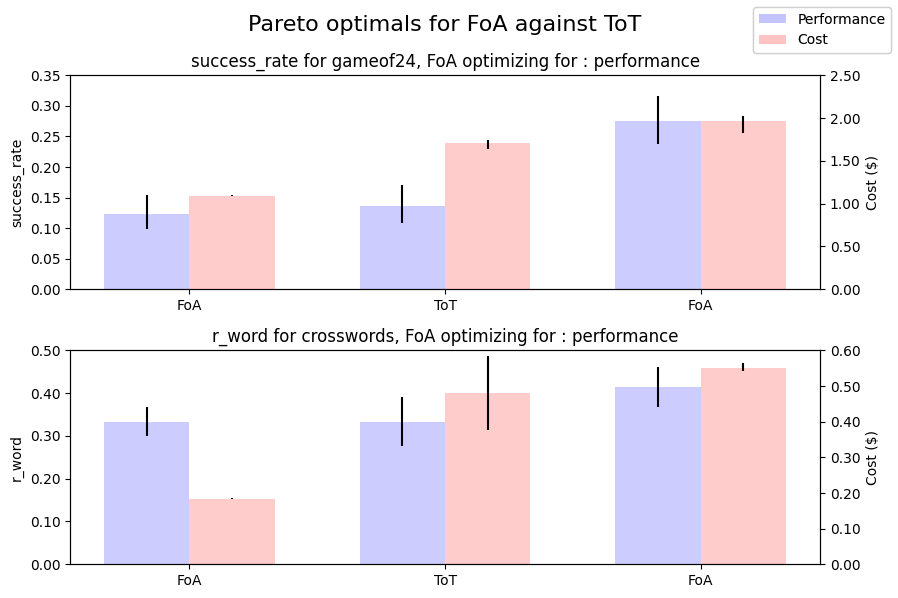

In [8]:
def plot_bars(df, metric_name, metric_axis,  title=None, maxy: tuple=None, show_optimization: bool=False ):

    cost_axis = metric_axis.twinx()

    width = 0.2

    df_foa = df#[df.method=="FoA"]
    if show_optimization:
        configurations = df.apply(lambda row: f"{row['method']}\n(Optimizing {row['optimization']})" if row["optimization"] else f"{row['method']}", axis=1).tolist()
    else:
        configurations = df["method"].tolist()
    # The x position of bars
    x_metric = [3*i*width for i in range(len(configurations)) ]
    x_cost = [x + width for x in x_metric]

    metric = df_foa["performance_mean"].array
    metric_ci_low = df_foa["performance_ci"].apply(lambda x: x[0]).array
    metric_ci_high= df_foa["performance_ci"].apply(lambda x: x[1]).array
    metric_ci = [np.abs(metric-metric_ci_low), np.abs(metric_ci_high-metric)]

    cost = df_foa["cost_mean"].array
    cost_ci_low = df_foa["cost_ci"].apply(lambda x: x[0]).array
    cost_ci_high= df_foa["cost_ci"].apply(lambda x: x[1]).array
    cost_ci = [np.abs(cost-cost_ci_low), np.abs(cost_ci_high-cost)]

    # Plot the bars
    metric_axis.bar(x_metric, metric, yerr=metric_ci, color="b", width=width,  alpha=0.2, label="Performance")
    cost_axis.bar(x_cost, cost, yerr=cost_ci, color="r", width=width,  alpha=0.2, label="Cost")

    # Handle axes and lebels
    metric_axis.set_ylabel(metric_name)
    cost_axis.set_ylabel("Cost ($)")
    plt.xticks([x + width/2 for x in x_metric], configurations)
    plt.title(title)

    # Combining legends
    lines, labels = metric_axis.get_legend_handles_labels()
    lines2, labels2 = cost_axis.get_legend_handles_labels()
    plt.figlegend(lines + lines2, labels + labels2)

    # Decimals on y axis
    metric_axis.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cost_axis.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Number of ticks in y axis
    n_bins = 8
    metric_axis.locator_params(axis="y", nbins=n_bins)
    cost_axis.locator_params(axis="y", nbins=n_bins)

    # Set ylim if specified
    if maxy:
        metric_axis.set_ylim((0, maxy[0]))
        cost_axis.set_ylim((0, maxy[1]))


maxy = {"gameof24": (0.35, 2.5), "crosswords": (0.5, 0.6)}
fig, axes = plt.subplots(2,1, figsize=(9,6))
for i, task in enumerate(["gameof24", "crosswords"]):
    df = pd.DataFrame()
    for j, optimization in enumerate(["cost", "performance"]):
        temp = group_data_per_optimization(data, benchmarks, optimization, task=task)
        df = pd.concat([df, temp])
    df.drop_duplicates(subset=["task", "method", "configuration"], keep="first", inplace=True)
    display(df)
    order = {"cost":0, None:1, "performance":2}
    df["order"] = df["optimization"].apply(lambda x: order[x])
    df.sort_values(by=["order"], inplace=True)
    metric=metrics[task]
    title = f"{metric} for {task}, FoA optimizing for : {optimization}"
    plot_bars(df, metric_axis=axes[i],metric_name=metric, title=title, maxy=maxy[task])

plt.suptitle("Pareto optimals for FoA against ToT", fontsize=16)
plt.tight_layout()
plt.savefig("pics/pareto_optimals2.pdf")
plt.show()

## GPT-4-Turbo powered evaluation function

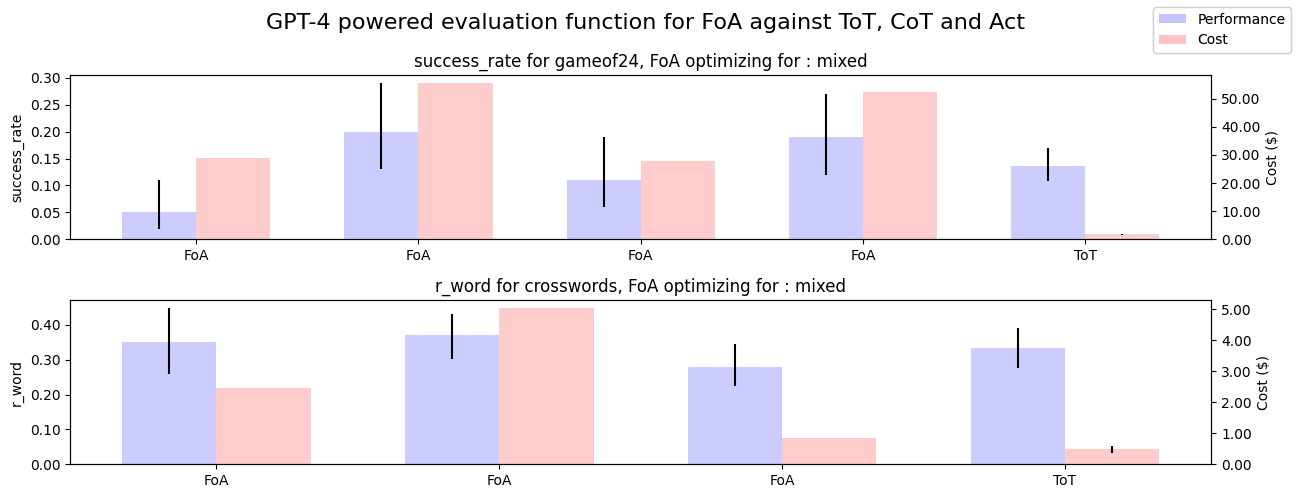

In [9]:
fig, axes = plt.subplots(2,1, figsize=(13,5))
optimization="mixed"
for i, task in enumerate(["gameof24", "crosswords"]):
    df = group_data_per_optimization(data, benchmarks, optimization, task=task)
    metric=metrics[task]
    title = f"{metric} for {task}, FoA optimizing for : {optimization}"
    plot_bars(df, metric_axis=axes[i],metric_name=metric, title=title)

plt.suptitle("GPT-4 powered evaluation function for FoA against ToT, CoT and Act", fontsize=16)
plt.tight_layout()
plt.savefig("pics/mixed.pdf")
plt.show()